- This notebook allows to compute the intrinsic alignment signal $w_{g+}$ of galaxies (projected 2D estimator) from a given survey
- Data : UNIONS shape catalogue matched with CMASS galaxy positions


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import linalg

from astropy.io import fits
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM

from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.coordinates import concatenate
from astropy import units as u

from matplotlib.patches import Ellipse
from scipy.spatial.transform import Rotation

import treecorr
import random

import torch
from torch.distributions import Uniform

from sbi.utils import BoxUniform
from sbi.analysis import pairplot
from sbi.inference import NPE, SNPE, simulate_for_sbi, infer
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
    prepare_for_sbi
)

/opt/homebrew/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# CMASS density tracers (North)

cmass_table = Table.read('/Users/antonincorinaldi/Documents/stage césure/data/galaxy_DR12v5_CMASS_North.fits')

names = [name for name in cmass_table.colnames if len(cmass_table[name].shape) <= 1]
filtered_tbl = cmass_table[names]

cmass_north = filtered_tbl.to_pandas()
cmass_north.columns

print(len(cmass_north))

618806


In [3]:
# CMASS density tracers (South)

cmass_table = Table.read('/Users/antonincorinaldi/Documents/stage césure/data/galaxy_DR12v5_CMASS_South.fits')

names = [name for name in cmass_table.colnames if len(cmass_table[name].shape) <= 1]
filtered_tbl = cmass_table[names]

cmass_south = filtered_tbl.to_pandas()
cmass_south.columns

print(len(cmass_south))

230831


In [4]:
# Combining North and South

cmass = pd.concat([cmass_north, cmass_south], ignore_index=True)

print(len(cmass))

849637


In [5]:
# UNIONS shape catalogue

with fits.open('/Users/antonincorinaldi/Documents/stage césure/data/unions_shapepipe_cut_struc_2024_v1.5.3.fits', memmap=True) as hdul:
    data = hdul[1].data
    selected_columns = ['RA', 'Dec','e1','e2']
    unions = pd.DataFrame({col: data[col].byteswap().newbyteorder() for col in selected_columns})

print(unions)

                   RA        Dec        e1        e2
0          108.370581  59.256291 -0.284876 -0.232650
1          108.643083  59.250135  0.195145  0.063940
2          107.871739  59.252632  0.159080  0.148219
3          108.441349  59.250404  0.180750 -0.529500
4          108.198100  59.250262  0.114629  0.160938
...               ...        ...       ...       ...
143256653  332.883595   3.715323  0.672961 -0.679813
143256654  332.877082   3.708592  0.472455  0.354313
143256655  332.884568   3.742759  0.183444  0.389572
143256656  332.874819   3.738361  0.324236 -0.577897
143256657  332.878778   3.722986  0.309631 -0.037124

[143256658 rows x 4 columns]


In [6]:
# Match between UNIONS and CMASS (tolerance of 1 arcsecond)

cat_unions = SkyCoord(ra= unions['RA'], dec=unions['Dec'],unit='deg')
cat_cmass = SkyCoord(ra=cmass['RA'] , dec=cmass['DEC'] , unit='deg')
idx, d2d, d3d = match_coordinates_sky(cat_unions, cat_cmass)

unions_cmass_cross = unions.loc[d2d.value < 0.00028]

print(len(unions_cmass_cross))

nb_unions_cmass = len(unions_cmass_cross)

unions_cmass_index = unions_cmass_cross.index
unions_cmass_index=np.array(unions_cmass_index)

idx2 = idx[d2d.value < 0.00028]
unions_cmass_cross2 = cmass.loc[idx2]

210440


Text(0.5, 0, 'Transverse separation [deg]')

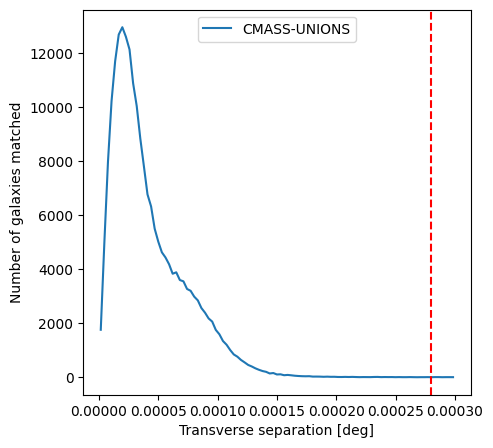

In [7]:
# Plot of the matched galaxies

d_bins = np.linspace(0,0.0003,100)
d_cents = (d_bins[1:] + d_bins[:-1])/2.

d_counts,_ = np.histogram(d2d.value, bins = d_bins)

plt.figure(figsize =(5,5))
plt.plot(d_cents, d_counts,label='CMASS-UNIONS',markersize = 4)
plt.axvline(0.00028,ls='--',color='red')
plt.legend()
plt.ylabel("Number of galaxies matched")
plt.xlabel("Transverse separation [deg]")

Text(0.5, 1.0, 'CMASS survey')

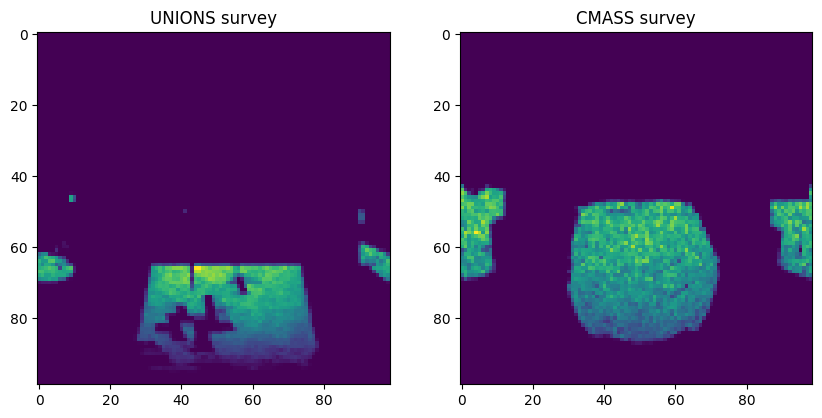

In [8]:
# Visualization of the surveys

ra_edges = np.linspace(0,360,100)
dec_edges = np.linspace( -90,90,100)

unions_survey,_,_ = np.histogram2d(unions['RA'], unions['Dec'], bins=(ra_edges, dec_edges))
unions_survey = unions_survey.T

cmass_survey,_,_ = np.histogram2d(cmass['RA'], cmass['DEC'], bins=(ra_edges, dec_edges))
cmass_survey = cmass_survey.T

plt.figure(figsize = (10,10))
plt.subplot(121)
plt.imshow(unions_survey)
plt.title("UNIONS survey")
plt.subplot(122)
plt.imshow(cmass_survey)
plt.title("CMASS survey")

In [9]:
# Distances and coordinates of CMASS-UNIONS galaxies

cosmo = FlatLambdaCDM(70,0.3)

chi_u = cosmo.comoving_distance(unions_cmass_cross2['Z'] ).value

x_u = chi_u * np.cos(unions_cmass_cross['RA'].values * np.pi/180) * np.cos(unions_cmass_cross['Dec'].values * np.pi/180)
y_u = chi_u * np.sin(unions_cmass_cross['RA'].values * np.pi/180) * np.cos(unions_cmass_cross['Dec'].values * np.pi/180)
z_u = chi_u * np.sin(unions_cmass_cross['Dec'].values * np.pi/180)

ra_u = unions_cmass_cross['RA'].values
dec_u = unions_cmass_cross['Dec'].values

e1_u = unions_cmass_cross['e1'].values
e2_u = unions_cmass_cross['e2'].values

In [10]:
# Computation of the wg+ signal for CMASS-UNIONS (reference : https://arxiv.org/pdf/2412.01790)

nrp = 21 ; npi = 51

shape_cat = treecorr.Catalog(x=x_u,y=y_u,z=z_u,g1=e1_u,g2=e2_u)

pi = np.linspace(-15,15,npi)

xi_gp = [] ; xi_gc = [] ; rp=[] ; var = [] ; covar = []
xi_gp=list(xi_gp) ; xi_gc = list (xi_gc) ; rp = list(rp) ; var = list(var) ; covar = list(covar)

for i in np.arange(0, npi-1):
    ng = treecorr.NGCorrelation(nbins=nrp,min_sep = 0.1,max_sep = 350.,min_rpar = pi[i],max_rpar = pi[i+1],bin_type='Log')
    ng.process(shape_cat, shape_cat, metric ='Rperp')
    xi, xi_im, varxi = ng.calculateXi(rg=None) ; r = ng.logr ; cov = ng.cov
    xi_gp.append(xi); xi_gc.append(xi_im); rp.append(r); var.append(varxi) ; covar.append(cov)
    
xi_gp=np.array(xi_gp); xi_gc=np.array(xi_gc); rp_unions=np.array(rp); var=np.array(var) ; covar=np.array(covar)

wgp_unions = np.zeros(nrp) ; wgc_unions = np.zeros(nrp) ; var2 = np.zeros(nrp)
for i in range (nrp):
    wgp_unions[i] = abs(np.sum(xi_gp[:,i]))
    wgc_unions[i] = abs(np.sum(xi_gc[:,i]))
    var2[i] = np.sum(var[:,i])

sigma_unions = np.sqrt(var2)

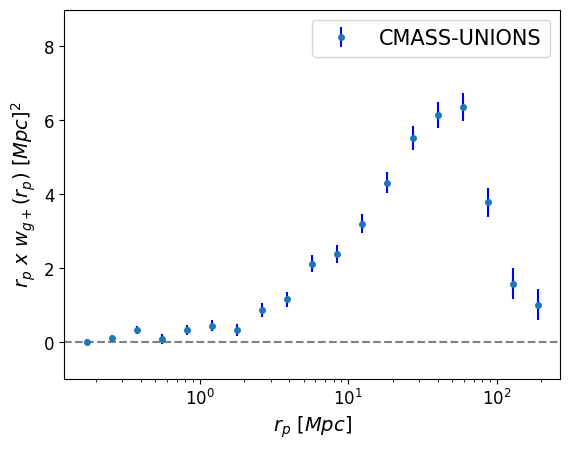

In [17]:
# Plot of the wg+ signal

plt.errorbar(np.exp(rp_unions[0,:len(wgp_unions)-2])/0.7,np.exp(rp_unions[0,:len(wgp_unions)-2])/0.7**2*wgp_unions[:len(wgp_unions)-2],yerr=np.exp(rp_unions[0,:len(wgp_unions)-2])/0.7*sigma_unions[:len(wgp_unions)-2],label='CMASS-UNIONS',
             ecolor='blue',marker='o', markersize = 4,linestyle='None')

plt.xlabel(r"$r_p~[Mpc]$",fontsize=14)
plt.ylabel(r"$r_p~x~w_{g+}(r_p)~[Mpc]^2$",fontsize=14)
plt.ylim(-1,9)
plt.xscale('log')
plt.axhline(0, ls='--', color='grey')
plt.legend(fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.savefig("wg+.pdf")

In [12]:
# Computation of the w++ signal for CMASS-UNIONS

nrp = 21 ; npi = 51

shape_cat = treecorr.Catalog(x=x_u,y=y_u,z=z_u,g1=e1_u,g2=e2_u)

pi = np.linspace(-15,15,npi)

xi_pp = [] ; rp=[] ; var = []
xi_pp = list(xi_pp) ; rp = list(rp) ; var = list(var)

for i in np.arange(0, npi-1):
    gg = treecorr.GGCorrelation(nbins=nrp,min_sep = 0.1,max_sep = 350.,min_rpar = pi[i],max_rpar = pi[i+1],bin_type='Log')
    gg.process(shape_cat, shape_cat, metric ='Rperp')
    xip = gg.xip ; varxi = gg.varxip ; r = ng.logr
    xi_pp.append(xip) ; var.append(varxi); rp.append(r) 
    
xi_pp=np.array(xi_pp) ; var=np.array(var) ; rp_unions=np.array(rp)

wpp_unions = np.zeros(nrp) ; var2 = np.zeros(nrp)
for i in range (nrp):
    wpp_unions[i] = abs(np.sum(xi_pp[:,i]))
    var2[i] = np.sum(var[:,i])

sigma_unions_pp = np.sqrt(var2)

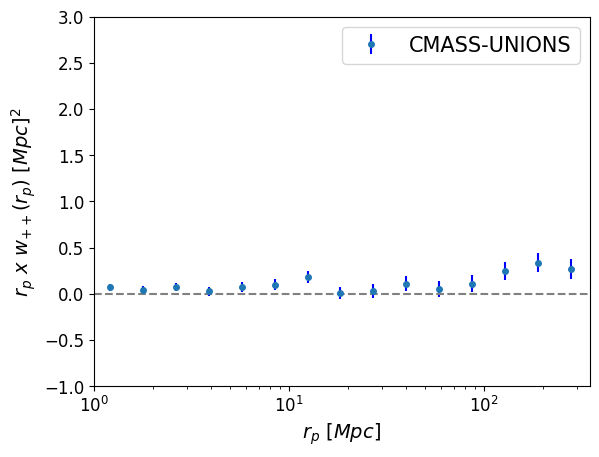

In [18]:
plt.errorbar(np.exp(rp_unions[0,:])/0.7, np.exp(rp_unions[0,:])/0.7**2*wpp_unions, yerr=np.exp(rp_unions[0,:])/0.7*sigma_unions_pp, label='CMASS-UNIONS', ecolor='blue', marker='o',
             markersize = 4, linestyle='None')

plt.xlabel(r"$r_p~[Mpc]$",fontsize=14)
plt.ylabel(r"$r_p~x~w_{++}(r_p)~[Mpc]^2$",fontsize=14)
plt.xscale('log')
plt.xlim(1,350)
plt.ylim(-1,3)
plt.axhline(0, ls='--', color='grey')
plt.legend(fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.savefig("w++.pdf")